In [12]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime , timezone
from sklearn.preprocessing import MinMaxScaler

In [13]:
COVALENT_API_KEY = "cqt_rQDKpBKC8BmDhw9X63xKGFCKBBVk" #this api key only at 7 august. i will attach the new key 
COVALENT_BASE = "https://api.covalenthq.com/v1/1/address/{wallet}/balances_v2/?key={api_key}"

In [14]:
wallet_df=pd.read_csv('Wallet id - Sheet1.csv')
wallets=wallet_df['wallet_id'].tolist()

In [18]:
wallets

['0x0039f22efb07a647557c7c5d17854cfd6d489ef3',
 '0x06b51c6882b27cb05e712185531c1f74996dd988',
 '0x0795732aacc448030ef374374eaae57d2965c16c',
 '0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9',
 '0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae',
 '0x104ae61d8d487ad689969a17807ddc338b445416',
 '0x111c7208a7e2af345d36b6d4aace8740d61a3078',
 '0x124853fecb522c57d9bd5c21231058696ca6d596',
 '0x13b1c8b0e696aff8b4fee742119b549b605f3cbc',
 '0x1656f1886c5ab634ac19568cd571bc72f385fdf7',
 '0x1724e16cb8d0e2aa4d08035bc6b5c56b680a3b22',
 '0x19df3e87f73c4aaf4809295561465b993e102668',
 '0x1ab2ccad4fc97c9968ea87d4435326715be32872',
 '0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f',
 '0x1e43dacdcf863676a6bec8f7d6896d6252fac669',
 '0x22d7510588d90ed5a87e0f838391aaafa707c34b',
 '0x24b3460622d835c56d9a4fe352966b9bdc6c20af',
 '0x26750f1f4277221bdb5f6991473c6ece8c821f9d',
 '0x27f72a000d8e9f324583f3a3491ea66998275b28',
 '0x2844658bf341db96aa247259824f42025e3bcec2',
 '0x2a2fde3e1beb508fcf7c137a1d5965f13a17825e',
 '0x330513970

In [28]:
def days_since(date_str):
    if not date_str:
        return 9999
    last_time=datetime.fromisoformat(date_str.replace('z','+00:00'))
    new_utc=datetime.now(timezone.utc)
    return (new_utc-last_time).days

In [29]:
def recent_activity_score(days):
    if days is None or days > 5000:  # Too old
        return 0.0
    return np.exp(-days / 365.0)

In [30]:
def fetch_wallet_covalent(wallet):
    url = COVALENT_BASE.format(wallet=wallet, api_key=COVALENT_API_KEY)
    resp = requests.get(url)
    if resp.status_code != 200:
        print(f" API error {resp.status_code} for {wallet}")
        return None
    
    data = resp.json().get("data", {})
    items = data.get("items", [])
    
    
    defi_tokens = [
        t for t in items 
        if any(proto in (t.get("contract_name") or "") for proto in ["Compound", "Aave"])
    ]
    
    total_value_usd = sum(float(t.get("quote") or 0) for t in defi_tokens)
    protocol_count = len(defi_tokens)
    
    last_activity_days = min(
        [days_since(t.get("last_transferred_at")) for t in defi_tokens],
        default=9999
    )
    
    return {
        "wallet_id": wallet,
        "total_value_usd": total_value_usd,
        "protocol_count": protocol_count,
        "last_activity_days": last_activity_days
    }

In [31]:
results = []
for i, w in enumerate(wallets, 1):
    print(f" Fetching {i}/{len(wallets)} → {w}")
    data = fetch_wallet_covalent(w)
    if data:
        results.append(data)

 Fetching 1/103 → 0x0039f22efb07a647557c7c5d17854cfd6d489ef3
 Fetching 2/103 → 0x06b51c6882b27cb05e712185531c1f74996dd988
 Fetching 3/103 → 0x0795732aacc448030ef374374eaae57d2965c16c
 Fetching 4/103 → 0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
 Fetching 5/103 → 0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae
 Fetching 6/103 → 0x104ae61d8d487ad689969a17807ddc338b445416
 Fetching 7/103 → 0x111c7208a7e2af345d36b6d4aace8740d61a3078
 Fetching 8/103 → 0x124853fecb522c57d9bd5c21231058696ca6d596
 Fetching 9/103 → 0x13b1c8b0e696aff8b4fee742119b549b605f3cbc
 Fetching 10/103 → 0x1656f1886c5ab634ac19568cd571bc72f385fdf7
 Fetching 11/103 → 0x1724e16cb8d0e2aa4d08035bc6b5c56b680a3b22
 Fetching 12/103 → 0x19df3e87f73c4aaf4809295561465b993e102668
 Fetching 13/103 → 0x1ab2ccad4fc97c9968ea87d4435326715be32872
 Fetching 14/103 → 0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f
 Fetching 15/103 → 0x1e43dacdcf863676a6bec8f7d6896d6252fac669
 Fetching 16/103 → 0x22d7510588d90ed5a87e0f838391aaafa707c34b
 Fetching 17/103 

In [32]:
risk_df = pd.DataFrame(results)
print("\n Raw features collected:")
display(risk_df.head())


 Raw features collected:


,wallet_id,total_value_usd,protocol_count,last_activity_days
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,76.302126,6,1317
1,0x06b51c6882b27cb05e712185531c1f74996dd988,3.546240,1,1743
2,0x0795732aacc448030ef374374eaae57d2965c16c,3.532434,1,1703
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,3.526495,1,1686
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,3.545356,1,1738


In [33]:
risk_df.fillna(0, inplace=True)

In [34]:
risk_df["activity_score"] = risk_df["last_activity_days"].apply(recent_activity_score)

In [35]:
features = ["total_value_usd", "protocol_count", "activity_score"]

In [36]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(risk_df[features])
scaled_df = pd.DataFrame(scaled, columns=[f"{c}_scaled" for c in features])

In [37]:
risk_df = pd.concat([risk_df, scaled_df], axis=1)

In [43]:
risk_df.head()

,wallet_id,total_value_usd,protocol_count,last_activity_days,activity_score,total_value_usd_scaled,protocol_count_scaled,activity_score_scaled,risk_score
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,76.302126,6,1317,0.027100,0.000047,0.333333,0.031578,106.0
1,0x06b51c6882b27cb05e712185531c1f74996dd988,3.546240,1,1743,0.008435,0.000002,0.000000,0.007685,2.0
2,0x0795732aacc448030ef374374eaae57d2965c16c,3.532434,1,1703,0.009412,0.000002,0.000000,0.008936,2.0
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,3.526495,1,1686,0.009861,0.000002,0.000000,0.009510,2.0
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,3.545356,1,1738,0.008552,0.000002,0.000000,0.007834,2.0


In [44]:
risk_df["risk_score"] = (
    0.5 * risk_df["total_value_usd_scaled"] +
    0.3 * risk_df["protocol_count_scaled"] +
    0.2 * risk_df["activity_score_scaled"]
) * 1000

In [45]:
risk_df["risk_score"] = risk_df["risk_score"].round(0)

In [46]:
final_df = risk_df[["wallet_id", "risk_score"]]
final_df.to_csv("wallet_risk_scores_improved2.csv", index=False)

In [50]:
final_df.sample(10)

,wallet_id,risk_score
61,0x8587d9f794f06d976c2ec1cfd523983b856f5ca9,2.0
33,0x4e6e724f4163b24ffc7ffe662b5f6815b18b4210,2.0
93,0xebb8629e8a3ec86cf90cb7600264415640834483,7.0
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,2.0
94,0xeded1c8c0a0c532195b8432153f3bfa81dba2a90,4.0
14,0x1e43dacdcf863676a6bec8f7d6896d6252fac669,2.0
40,0x58d68d4bcf9725e40353379cec92b90332561683,156.0
13,0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f,22.0
57,0x7f5e6a28afc9fb0aaf4259d4ff69991b88ebea47,2.0
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,106.0


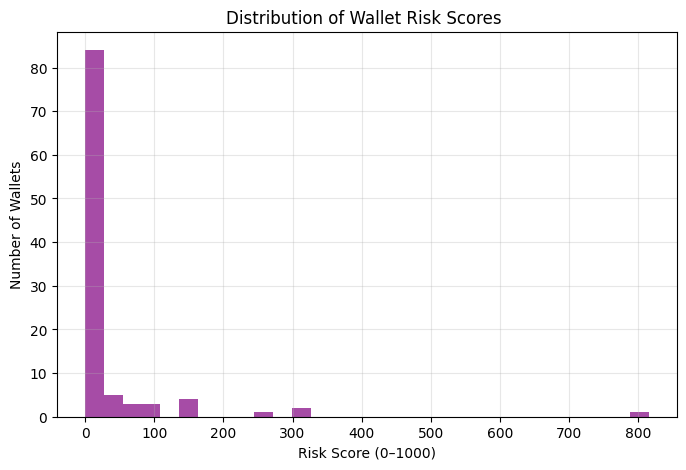

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(risk_df["risk_score"], bins=30, color="purple", alpha=0.7)
plt.title("Distribution of Wallet Risk Scores ")
plt.xlabel("Risk Score (0–1000)")
plt.ylabel("Number of Wallets")
plt.grid(True, alpha=0.3)
plt.show()